In [1]:
from ultralytics import YOLO
import cv2
from tqdm import tqdm
import numpy as np 
from PIL import Image 
from sklearn.metrics.pairwise import cosine_similarity

/Users/ivan/miniconda3/envs/py38/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [ ]:
# download yolo faces here:
# https://github.com/derronqi/yolov8-face

In [2]:
model_cls = YOLO("yolov8n-cls.pt")
model_segment_faces = YOLO("yolov8n-face.pt")
model_segment_people = YOLO("yolov8s.pt")

Перемотка до начала квеста


100%|██████████| 1697/1697 [00:17<00:00, 99.32it/s] 

0: 352x640 1 face, 48.7ms
Speed: 2.1ms preprocess, 48.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


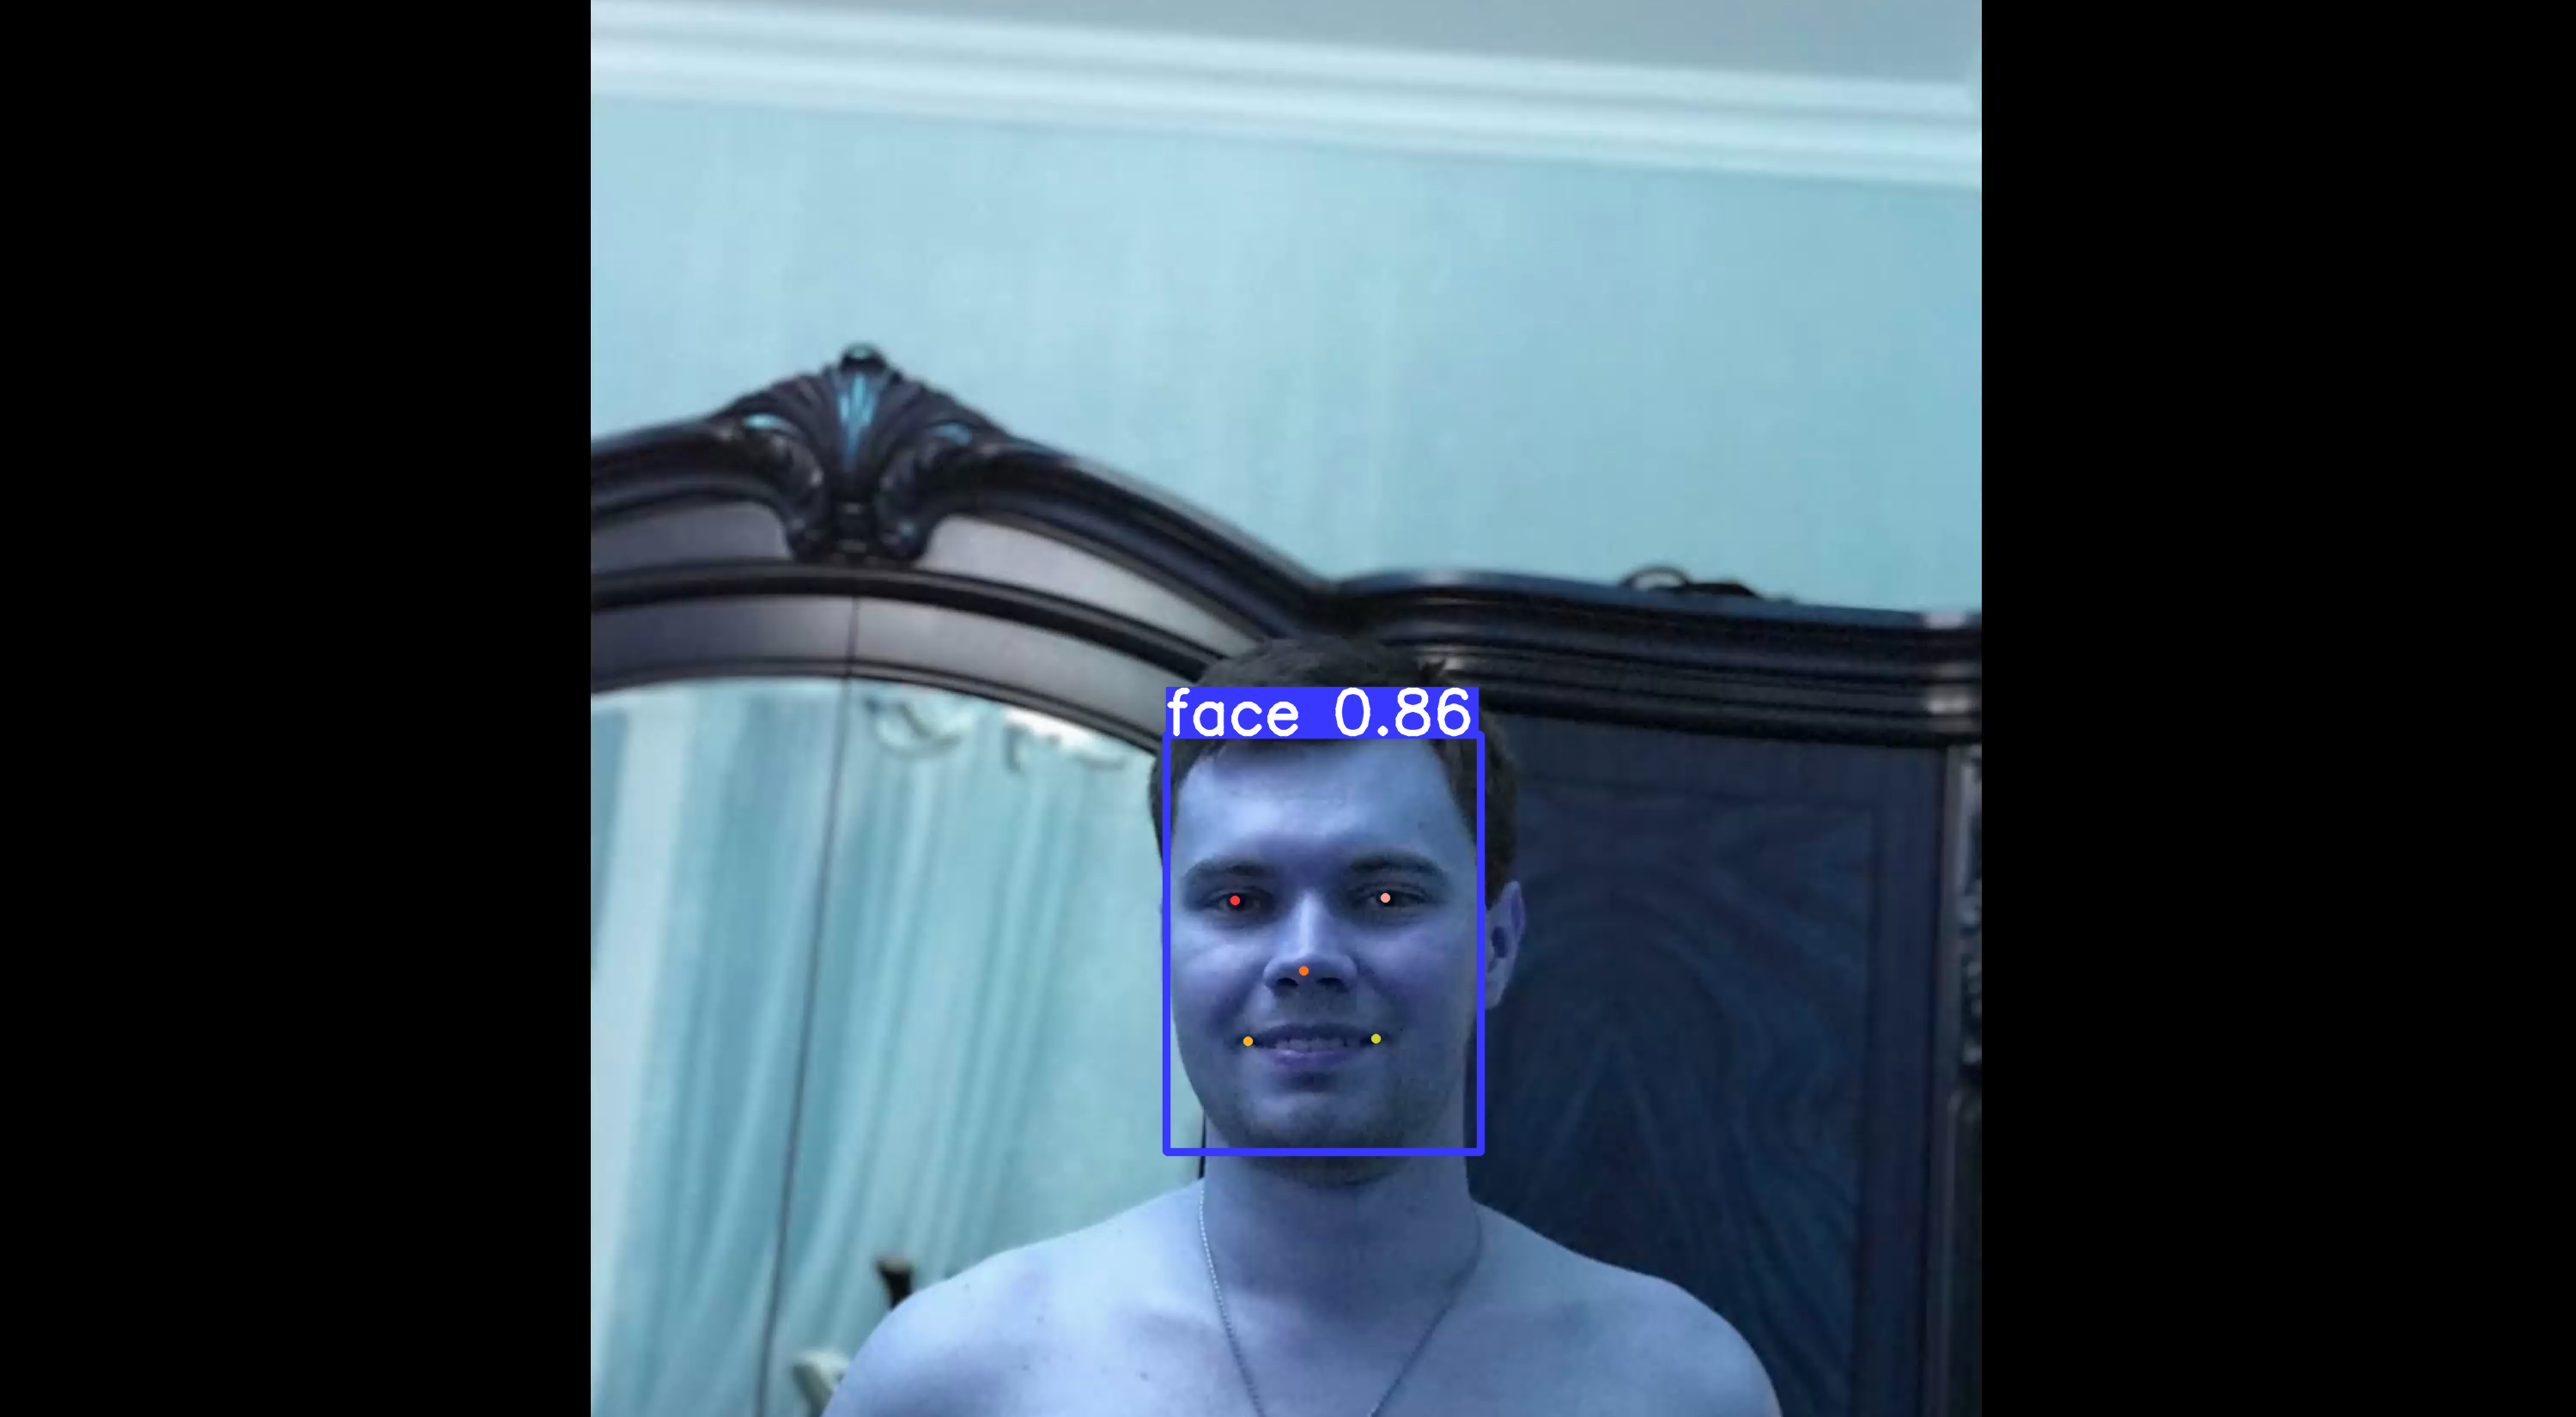

In [3]:
vidcap = cv2.VideoCapture('/Users/ivan/Downloads/Ванечке-1.mp4')

video_cnt_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
video_time_len = 2 * 60 + 29# in seconds
start_quest_time = 28.32 # in seconds
end_quest_time = 2 * 60 + 27.1 # in seconds
frame_time_len = video_time_len / video_cnt_frames
start_quest_frame = int(video_cnt_frames * start_quest_time / video_time_len)
end_quest_frame = int(video_cnt_frames * end_quest_time / video_time_len)

print('Перемотка до начала квеста')
for frame_n in tqdm(range(0, start_quest_frame)):
    success, image = vidcap.read()
center_box_old = image[250:1900, 550:3550, :] # the last one frame before quest

res = model_segment_faces.predict(center_box_old)
Image.fromarray(res[0].plot())

In [135]:
is_the_same_time_len = 0
is_the_same_time_treshold_up = 0.7
is_the_same_time_treshold_down = 0.1
morze_code = ''
times = []
sims = []

def calc_sim(box1, box2):
    pred_old = model_cls.predict(box1, verbose=False)[0].probs.numpy().data
    pred_current = model_cls.predict(box2, verbose=False)[0].probs.numpy().data
    return cosine_similarity([pred_old], [pred_current])

def is_the_space(box):
    faces_pred = model_segment_faces.predict(box, verbose=False)[0]
    items = [faces_pred.names[int(box.cls.numpy()[0])] for box in faces_pred.boxes if box.conf[0] > 0.5]
    if len(items) == 0:
        return False
    if 3 <= (np.array(items) == 'face').sum():
        persons_pred = model_segment_people.predict(box, verbose=False)[0]
        items = [persons_pred.names[int(box.cls.numpy()[0])] for box in persons_pred.boxes]
        return 2 <= (np.array(items) == 'person').sum()
    return False
    

is_space = False
print('Анализ квеста')
pbar = tqdm(range(start_quest_frame, end_quest_frame))
for frame_n in pbar:
    pbar.set_description(f"code = '{morze_code}' is_space={is_space}")
    try:
        success, image = vidcap.read()
    except Exception as e:
        print('End of the video?', str(e))
        break

    center_box_current = image[250:1900, 550:3550, :]

    # является ли фото - пробелом
    if is_the_space(center_box_current):
        if not is_space:
            if is_the_same_time_len > is_the_same_time_treshold_up:
                symbol = '- '
            elif is_the_same_time_treshold_down < is_the_same_time_len < is_the_same_time_treshold_up:
                symbol = '. '
            else:
                symbol = ''
            morze_code += symbol
            times.append({'len': is_the_same_time_len, 'sim': None, 'frame': frame_n, 'symbol': symbol})
            is_the_same_time_len = 0
        is_space = True
        center_box_old = center_box_current
        continue
    else:
        is_space = False

    # если фото - не пробел, то как долго оно уже длится
    similarity = calc_sim(center_box_current, center_box_old)
    sims.append(similarity)
    if similarity > 0.9:
        is_the_same_time_len += frame_time_len
    else:
        if is_the_same_time_len > is_the_same_time_treshold_up:
            symbol = '-'
        elif is_the_same_time_treshold_down < is_the_same_time_len < is_the_same_time_treshold_up:
            symbol = '.'
        else:
            symbol = ''
        morze_code += symbol
        times.append({'len': is_the_same_time_len, 'sim': similarity, 'frame': frame_n, 'symbol': symbol})
        is_the_same_time_len = 0
    
    center_box_old = center_box_current

times.append({'len': is_the_same_time_len, 'sim': similarity, 'frame': frame_n})
if is_the_same_time_len > is_the_same_time_treshold_up:
    morze_code += '-'
elif is_the_same_time_treshold_down < is_the_same_time_len < is_the_same_time_treshold_up:
    morze_code += '.'

print(morze_code)


100%|██████████| 1697/1697 [00:20<00:00, 83.11it/s]
code = '.-- .- -. .-.- - -.-- .-.. ..- ---. ---- .. .--- -- -.-- .-.. ..-- -... .. -- - . -... .-.' is_space=False: 100%|██████████| 7118/7118 [12:28<00:00,  9.52it/s]

.-- .- -. .-.- - -.-- .-.. ..- ---. ---- .. .--- -- -.-- .-.. ..-- -... .. -- - . -... .-.-


In [139]:
codes = {
    '.-': 'а',
    '.......': ' ',
    '-...': 'б',
    '.--': 'в',
    '--.': 'г',
    '-..': 'д',
    '.': 'е',
    '...-': 'ж',
    '--..•': 'з',
    '..': 'и',
    '.---': 'й',
    '-.-': 'к',
    '.-..': 'л',
    '--': 'м',
    '-.': 'н',
    '---': 'ц',
    '.--.': 'п',
    '.-.': 'р',
    '...': 'с',
    '-': 'т',
    '..-': 'у',
    '..-.': 'ф',
    '....': 'х',
    '-.-.': 'ц',
    '---.': 'ч',
    '----': 'ш',
    '--.-': 'щ',
    '--.--': 'ъ',
    '-.--': 'ы',
    '..--': 'ю',
    '.-.-': 'я',
    '.----': '1',
    '..---': '2',
    '...--': '3',
    '....-': '5',
    '.....': '5',
    '-....': '6',
    '--...': '7',
    '---..•': '8',
    '----.': '9',
    '-----': '0',
    '......': '. ',
    '.-.-.-': ', ',
    '---...': ':',
    '-.-.-': ';',
    '-.--.-': '',
    '.-..-.': '',
    '..--..': '?',
    '--..--': '!',
    '.--.-.': '@',
    '-....-': '-'
}

def decryption(morze_code):
    decrypted = []
    for letter_code in morze_code.split(' '):
        decrypted.append({'code': letter_code, 'letter': codes[letter_code]})
    return decrypted

def show_decryption(morze_code):
    print(morze_code)
    decrypted = decryption(morze_code)
    decripted_str = ''
    for letter in decrypted:
        decripted_str += letter['letter'] + ' '*(len(letter['code']))
    print(decripted_str)

show_decryption(morze_code)

.-- .- -. .-.- - -.-- .-.. ..- ---. ---- .. .--- -- -.-- .-.. ..-- -... .. -- - . -... .-.-
в   а  н  я    т ы    л    у   ч    ш    и  й    м  ы    л    ю    б    и  м  т е б    я    
